# Blue Book for Bulldozers

## Objective

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

**Evaluation:** The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## Table of Contents
**1. Load and Check Data**

    1.1 Importing Data
    1.2 Transform SalePrice
    1.3 Expand Date Information
    1.4 Change String Column Into Categorical
    1.5 Specify Category Order
**2. Data Pre-processing**
**3. Data Modelling & Prediction**

    3.1 Split Data into Train and Val
    3.2 Random Forest Regression
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.3 Random Forest Classifier
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.4 Stochastic Gradient Descent
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.5 Summary
**4. Conclusion**

## 1. Load and Check Data

### 1.1 Importing Data

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [36]:
from src.fastai.imports import *
from src.fastai.structured import *

from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [37]:
df_raw = pd.read_csv('data/01_raw/train.csv', low_memory=False, parse_dates=['saledate'])

In [38]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [39]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


### 1.2 Transform Sale Price

Because we're going to evaluate using RSMLE. So we're going to transform SalePrice into log form

In [40]:
df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

### 1.3 Expand Date Information

In [41]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

### 1.4 Change String Column into Categorical

In [42]:
train_cats(df_raw)

### 1.5 Specify Category Order

In [43]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [44]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

## 2. Data Pre-Processing

### 2.1 Missing Values

In [45]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [46]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [47]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
print("R-squared", m.score(df,y))

C:\Users\BPS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-squared 0.8801181514363107


## 3. Data Modelling & Prediction

### 3.1  Split Data into Train and Val

In [48]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_val = 12000  # same as Kaggle's test set size
n_train = len(df)-n_val
raw_train, raw_val = split_vals(df_raw, n_train)
X_train, X_val = split_vals(df, n_train)
y_train, y_val = split_vals(y, n_train)

In [49]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train), m.score(X_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### 3.2 Random Forest Regression

In [50]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\BPS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 1.79 s
[0.23942857471852977, 0.27482241768710486, 0.8801917329050718, 0.8651185314463965]


#### 3.2.1 Speed things up

In [51]:
#take a sample
df_train, y_train, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_train, 20000)
y_train, _ = split_vals(y_train, 20000)

In [52]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\BPS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 388 ms
[0.11074145974684801, 0.3718199448160207, 0.9731559236632367, 0.7531044069174923]


#### 3.2.2 Single tree

In [53]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5240647029914357, 0.5805555571688659, 0.39882931175534986, 0.39808447221250715]


Let's see what happens if we create a bigger tree.

In [54]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.526751786450488e-17, 0.5196957795349364, 1.0, 0.5176676912896273]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

#### 3.2.3 Bagging

We'll grab the predictions for each individual tree, and look at one example.

In [75]:
preds = np.stack([t.predict(X_val) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_val[0]

(array([ 9.6486 ,  9.13238,  9.30565,  9.04782,  9.10498,  9.30565,  9.21034,  8.92266,  9.4727 ,  9.10498,
        10.16585,  9.21034,  9.43348,  9.15905,  9.13238,  9.74097,  9.15905,  8.9872 ,  9.39266,  9.25913,
         9.15905,  9.30565,  9.21034,  8.95545,  9.10498,  9.30565,  9.76996,  9.39266,  9.13238,  9.01189,
         8.95545,  9.10498,  9.68034,  9.30565,  8.9872 ,  9.3501 ,  9.17988,  8.9872 ,  9.04782,  9.32812]),
 9.254265352319555,
 9.104979856318357)

In [76]:
preds.shape

(40, 12000)

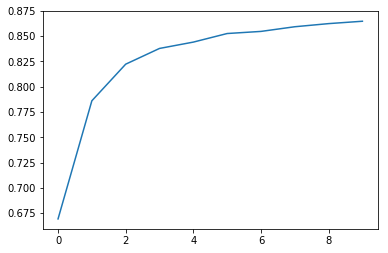

In [77]:
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [58]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09244785071678945, 0.35838161979124367, 0.9812922475232109, 0.7706285130220567]


#### 3.2.4 Out-of-bag (OOB) score

In [59]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09462717626236934, 0.3479028973856238, 0.9803998344916901, 0.7838456075317708, 0.8578670431510274]


#### 3.2.5 Reduce Overfit

Subsampling

In [70]:
df_train, y_train, nas = proc_df(df_raw, 'SalePrice')
X_train, X_val = split_vals(df_train, n_train)
y_train, y_val = split_vals(y_train, n_train)

In [71]:
set_rf_samples(20000)

In [72]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\BPS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 2.9 s
[0.23930563053015289, 0.2777891458515866, 0.880314742018677, 0.8621907025216768, 0.8677811844780214]


In [73]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 8.73 s
[0.2272107663541153, 0.2629588300880055, 0.8921071564736008, 0.8765123597278832, 0.8806044251531314]
